# 构建地图

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform, morphology

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## 处理地图

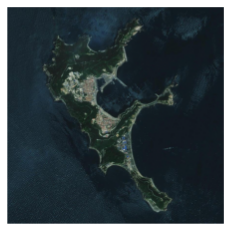

In [123]:
# 导入图片 original map
omg = io.imread("../Resources/Environment/890c.png")
omg = np.flip(omg, 0) # 图片翻转
omg = transform.resize(omg, (500, 500)) # 大小
plt.axis("off"), plt.gray()
plt.xlim(0, omg.shape[1])
plt.ylim(0, omg.shape[0])
plt.imshow(omg)

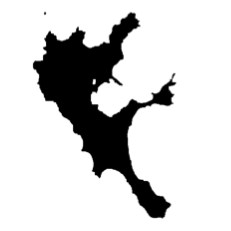

In [88]:
# 转换为灰度图并二值化 (这里选的是另一个更方便的图)
img = io.imread("../Resources/Environment/map_original.png")

img = color.rgb2gray(img)
img = transform.resize(img, (500, 500))
img = img < 0.44

img = np.flip(img, 0)  # 图片翻转, 图片坐标原点转换到左下角

img = morphology.binary_closing(img)  # 消除小黑点
img = morphology.binary_opening(img, np.ones((6, 6)))

plt.axis("off"), plt.gray()
plt.xlim(0, img.shape[1])
plt.ylim(0, img.shape[0])
plt.imshow(img)  # 得到一个 500x500 大小的地图


地图大小 500x500; 0表示不可通行, 1表示可以

图片矩阵的y坐标是从上往下数的, `(x,y)`其实是 `data[y,x]`.  
但是习惯上从左下角开始数, 比如 scatter 之类的似乎总是从左下角开始.
所以只需要注意一点, 就是访问图片坐标时倒过来就好, 其他正常.

## 生成目标点

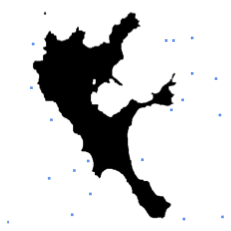

In [96]:
import random

obstacle = morphology.binary_erosion(img, np.ones((10,10)))  # 扩大障碍物判定范围
target = []
while len(target) < 20:
    p = (random.randint(0, 499), random.randint(0, 499))
    if obstacle[p[1], p[0]]:
        target.append(p)
else:
    target = np.array(target)  # 最后转变为 ndarray

plt.axis("off"), plt.gray()
plt.xlim(0, img.shape[1])
plt.ylim(0, img.shape[0])
plt.imshow(img)
plt.scatter(target[:, 0], target[:, 1], color="#6495ED", s=5, marker="x")


## 存档点

In [127]:
# 保存目标点
import pickle
import time

# 数据保存在 assets 下面

def save(var, name="data"):
    time_str = time.strftime("%Y%m%d%H%M%S")
    filename = f"{time_str} {name}.pickle"
    filepath = f"assets/{filename}"
    with open(filepath, 'wb') as f:
        pickle.dump(var, f)

    print("save {} to \"{}\"".format(type(var), filepath))

def load(filename):
    with open(f"assets/{filename}", 'rb') as f:
        data = pickle.load(f)
    return data

# save(target, "targets")
# save(img, "map")
# save(omg, "original_map")
target = load("20220423164508 targets.pickle")
img = load("20220423164508 map.pickle")
omg = load("20220423171747 original_map.pickle")


# 分配任务点

## 构建邻接矩阵

距离是按照像素计算的.

warning: 
- 20 个目标点会计算 3min
- 30 个目标点会计算 4-5min

In [106]:
from assets.astar import GridWithWeights, a_star_search, reconstruct_path

target_list = [(t[0],t[1]) for t in target]
graph = GridWithWeights(img)


def get_distance(graph, start, goal):
    came_from, cost_so_far = a_star_search(graph, start, goal)
    path = reconstruct_path(came_from, start, goal)
    return len(path) - 1


n = len(target_list)
adj = np.ones((n, n)) # adjacency matrix
for i, p1 in enumerate(target_list):
    for j, p2 in enumerate(target_list[i + 1:]):
        # 计算 P1,P2 之间的距离
        distance = get_distance(graph, p1, p2)
        # 矩阵对应位置赋值
        adj[[i, i + j + 1], [i + j + 1, i]] = distance

调参确定 gamma, gamma 越小, 数据越靠近1

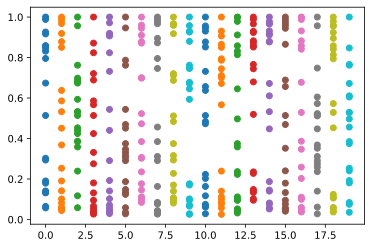

In [115]:
gamma = 5e-6
affinity_matrix = np.exp(-gamma * adj**2)
for i in affinity_matrix:
    for index, j in enumerate(i):
        if j != 1.0:
            plt.scatter(index, j)

## 聚类

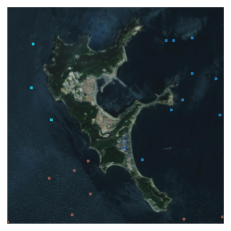

In [126]:
# from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

# 前面算好 affinity_matrix
cluster = 3
sc = SpectralClustering(n_clusters=cluster, affinity='precomputed')
result_sc = sc.fit_predict(affinity_matrix)

plt.axis("off")
plt.xlim(0, omg.shape[1])
plt.ylim(0, omg.shape[0])
plt.imshow(omg)
# plt.scatter(target[:, 0], target[:, 1], color="#6495ED", s=6)  # 画上目标点

plt.scatter(target[:, 0],
            target[:, 1],
            c=result_sc,
            marker='x',
            s=5,
            cmap="tab10")  # 画上目标点

## 存档点

In [137]:
readme = """
img: 20220423164508 map.pickle
omg: 20220423171747 original_map.pickle
target: 20 个目标点 ndarry 20220423164508 targets.pickle
cluster: 3 个聚类结果
affinity_matrix: 邻接矩阵
"""

MAP = {
    "omg": omg,  # 底图
    "img": img,  # 二值化后障碍信息
    "target": target,  # 目标点
    "cluster": result_sc,  # 目标点聚类结果(聚类数自己看)
    "affinity_matrix": affinity_matrix,  # 邻接矩阵, 以免想要重新聚类
    "readme": readme
}

# save(MAP,"MAP")
MAP = load("20220423172802 MAP.pickle")


# 路径规划

In [ ]:
" 画图 "


def plot_path(img, targets, network):
    fig = plt.figure()
    axis = fig.subplots()
    axis.set_xlim(0, img.shape[1])
    axis.set_ylim(0, img.shape[0])
    plt.axis("off")
    axis.imshow(img)  # 画地图

    axis.scatter(targets[:, 0], targets[:, 1], marker='x', s=2.5,
                 c="r")  # 画任务点
    axis.plot(network[:, 0], network[:, 1])  # 画路线
    return plt.axis